In [1]:
%matplotlib inline
import sys, os, time

import numpy as np
import pandas as pd

import fiona
import rasterio

import matplotlib.pyplot as plt

from collections import Counter, defaultdict

In [2]:
f = fiona.open("../data/good_blobs_epsg4326.shp","r")
fns = []
for line in f:
    fns.append(line["properties"]["location"])
f.close()

In [3]:
state_year_fns = defaultdict(list)
for fn in fns:
    parts = fn.split("/")
    state_year_fns[parts[9]].append(fn)

In [4]:
for k, vs in state_year_fns.items():
    print(k, len(vs))

md_1m_2013 823
va_1m_2014 2056
pa_1m_2013 2430
wv_1m_2014 594
nc_1m_2014 9
ny_1m_2013 1308
nj_1m_2013 27
md_1m_2015 9
de_1m_2013 144


In [5]:
good_blobs_to_best_tiles_map = {}
f = open("../data/good_blobs_to_best_tiles_map.csv", "r")
f.readline()
lines = f.read().strip().split("\n")
for line in lines:
    parts = line.split(",")
    good_blobs_to_best_tiles_map[parts[0]] = parts[1]
f.close()

In [62]:
for k, vs in state_year_fns.items():
    
    samples = np.random.choice(vs, min(len(vs), 50), replace=False)
    print(k, len(samples))
    f = open("splits/%s_test_split.csv" % (k),"w")
    f.write("naip_path,lc_path,nlcd_path\n")
    for i, naip_fn in enumerate(samples):
        lc_fn = naip_fn.replace("esri-naip", "resampled-lc")[:-4] + "_lc.tif"
        nlcd_fn = good_blobs_to_best_tiles_map[naip_fn].replace("esri-naip", "resampled-nlcd")[:-4] + "_nlcd.tif"
        f.write("%s,%s,%s\n" % (naip_fn, lc_fn, nlcd_fn))
    f.close()

nj_1m_2013 27
wv_1m_2014 50
md_1m_2013 50
va_1m_2014 50
md_1m_2015 9
pa_1m_2013 50
de_1m_2013 50
ny_1m_2013 50
nc_1m_2014 9


In [64]:
def get_lc_stats(data):
    vals = [1, 2, 3, 4, 5, 6, 15]
    counts = []
    for val in vals:
        counts.append((data==val).sum())
    return np.array(counts)

In [65]:
lc_counts = {}
for k, vs in state_year_fns.items():
    print(k)
    
    df = pd.read_csv("splits/%s_test_split.csv" % (k))
    naip_fns =  df["naip_path"].values
    lc_fns = df["lc_path"].values
    nlcd_fns = df["nlcd_path"].values
    
    counts = []
    for i in range(len(naip_fns)):
        f = rasterio.open(lc_fns[i],"r")
        lc_data = f.read().squeeze()
        f.close()
        
        assert os.path.exists(nlcd_fns[i])
        
        counts.append(get_lc_stats(lc_data))
        
    lc_counts[k] = np.array(counts)

nj_1m_2013
wv_1m_2014
md_1m_2013
va_1m_2014
md_1m_2015
pa_1m_2013
de_1m_2013
ny_1m_2013
nc_1m_2014


In [67]:
for k, vs in state_year_fns.items():
    
    df = pd.read_csv("splits/%s_test_split.csv" % (k))
    naip_fns =  df["naip_path"].values
    lc_fns = df["lc_path"].values
    nlcd_fns = df["nlcd_path"].values
    
    f = open("splits/%s_test_split_lc_counts.csv" % (k),"w")
    f.write("naip_path,count lc 1,count lc 2,count lc 3,count lc 4,count lc 5,count lc 6,count lc 15\n")
    for i in range(len(naip_fns)):
        f.write("%s," % (naip_fns[i]))
        for j in range(lc_counts[k].shape[1]):
            f.write("%d" % (lc_counts[k][i,j]))
            if j < lc_counts[k].shape[1]-1:
                f.write(",")
        f.write("\n")
    f.close()

In [72]:
for k, vs in state_year_fns.items():
    print(k)
    for count in lc_counts[k]:
        print("\t",np.round(count/count.sum(), 2))

nj_1m_2013
	 [0.06 0.3  0.19 0.   0.22 0.03 0.2 ]
	 [0.02 0.14 0.07 0.   0.02 0.01 0.74]
	 [0.05 0.21 0.08 0.   0.11 0.02 0.54]
	 [0.02 0.14 0.02 0.   0.   0.   0.82]
	 [0.01 0.05 0.07 0.01 0.02 0.   0.84]
	 [0.   0.   0.   0.   0.01 0.   0.98]
	 [0.08 0.01 0.05 0.   0.06 0.   0.8 ]
	 [0.02 0.16 0.1  0.01 0.01 0.   0.7 ]
	 [0.02 0.29 0.39 0.01 0.02 0.01 0.27]
	 [0.03 0.33 0.26 0.01 0.3  0.05 0.02]
	 [0.09 0.04 0.04 0.01 0.22 0.05 0.55]
	 [0.02 0.46 0.34 0.   0.04 0.01 0.12]
	 [0.02 0.32 0.26 0.01 0.3  0.07 0.02]
	 [0.04 0.59 0.17 0.   0.01 0.01 0.19]
	 [0.01 0.08 0.04 0.   0.01 0.   0.86]
	 [0.01 0.04 0.01 0.   0.   0.   0.94]
	 [0.01 0.4  0.45 0.   0.07 0.02 0.04]
	 [0.01 0.   0.   0.   0.   0.   0.98]
	 [0.11 0.11 0.09 0.   0.18 0.04 0.47]
	 [0.05 0.07 0.05 0.02 0.05 0.   0.75]
	 [0.15 0.05 0.09 0.01 0.1  0.02 0.58]
	 [0.28 0.22 0.2  0.07 0.13 0.02 0.09]
	 [0.01 0.05 0.01 0.   0.   0.   0.92]
	 [0.01 0.45 0.24 0.   0.18 0.04 0.08]
	 [0.02 0.27 0.04 0.   0.   0.   0.67]
	 [0.   0.23 0

nj_1m_2013
[0.096 0.402 0.274 0.013 0.177 0.037]


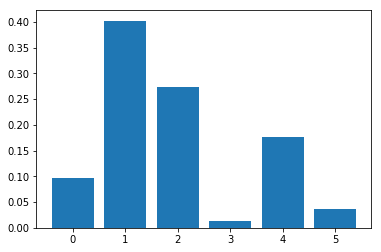

wv_1m_2014
[0.006 0.761 0.217 0.001 0.01  0.005]


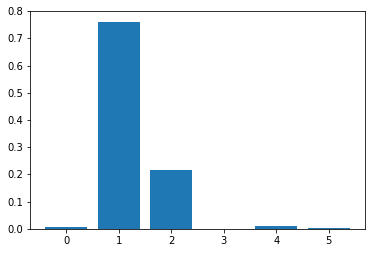

md_1m_2013
[0.147 0.437 0.34  0.004 0.052 0.021]


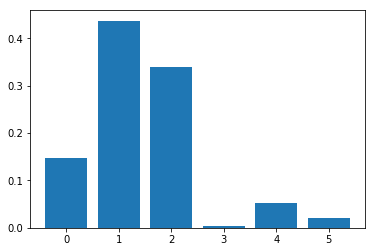

va_1m_2014
[0.038 0.758 0.185 0.001 0.009 0.009]


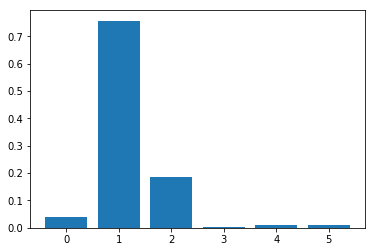

md_1m_2015
[0.361 0.276 0.296 0.002 0.052 0.012]


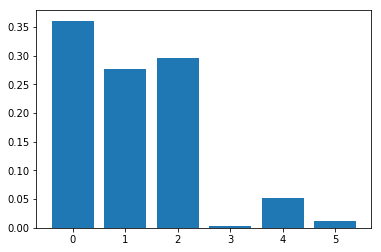

pa_1m_2013
[0.02  0.615 0.305 0.004 0.042 0.014]


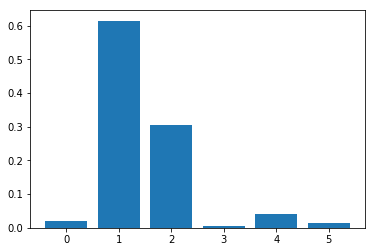

de_1m_2013
[0.038 0.365 0.527 0.007 0.042 0.02 ]


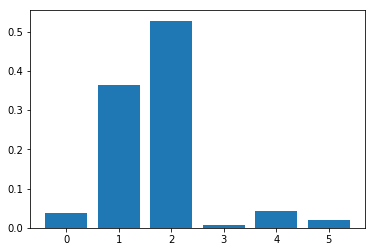

ny_1m_2013
[0.041 0.598 0.331 0.001 0.015 0.013]


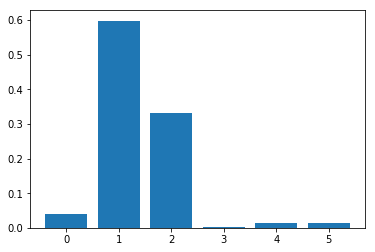

nc_1m_2014
[0.153 0.583 0.242 0.012 0.006 0.004]


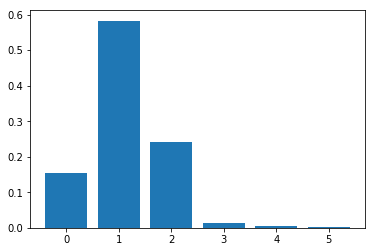

In [77]:
for k, vs in state_year_fns.items():
    print(k)
    summed_counts = lc_counts[k].sum(axis=0)
    summed_counts = summed_counts[:-1]
    print(np.round(summed_counts/summed_counts.sum(), 3))
    
    plt.figure()
    plt.bar(range(6),summed_counts/summed_counts.sum())
    #plt.
    plt.show()
    plt.close()